In [1]:
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np

np.set_printoptions(suppress=True)

import data_handler as dh
import sinkhorn as skh
import model as md
import csv
import pandas as pd

from conf import parsers

nodes_name = None

best_sink_beta = 0.001
sink_num_iter, sink_eps = 25000, 10 ** (-8)
INF_COST = 100
INF_TIME = 1e10


def get_times_inverse_func(capacity, times, rho=0.15, mu=0.25):
    capacities = capacity.to_numpy()
    freeflowtimes = times
    return np.transpose((capacities / rho) * (np.power(times / freeflowtimes, mu) - 1.0))


def get_LW(L_dict, W_dict, new_to_old):
    L = np.array([L_dict[new_to_old[i]] for i in range(len(L_dict))], dtype=np.double)
    W = np.array([W_dict[new_to_old[i]] for i in range(len(W_dict))], dtype=np.double)
    people_num = L.sum()
    L /= np.nansum(L)
    W /= np.nansum(W)
    return L, W, people_num

handler = dh.DataHandler()
graph_data = handler.GetGraphData(eval(f'handler.{parsers}_net_parser'),
                                  columns=['init_node', 'term_node', 'capacity', 'free_flow_time', 'xa', 'xb', 'ya', 'yb'])

L_dict, W_dict = handler.GetLW_dicts(eval(f'handler.{parsers}_corr_parser'))
handler.save_input_data_to_res(graph_data, L_dict, W_dict)

handler = dh.DataHandler()

max_iter = 2
alpha = 0.9

empty_corr_dict = {source: {'targets': list(W_dict.keys())} for source in L_dict.keys()}
empty_corr_matrix, old_to_new, new_to_old = handler.reindexed_empty_corr_matrix(empty_corr_dict)
print('fill correspondence_matrix')

L, W, people_num = get_LW(L_dict, W_dict, new_to_old)
total_od_flow = people_num

print(f'L, W, people_num {L, W, people_num}, total_od_flow: {total_od_flow}')
model = md.Model(graph_data, empty_corr_dict, total_od_flow, mu=0.25)
T_dict = handler.get_T_from_t(graph_data['graph_table']['free_flow_time'],
                              graph_data, model)
T = handler.T_matrix_from_dict(T_dict, empty_corr_matrix.shape, old_to_new)

for ms_i in range(12):

    print('iteration: ', ms_i)

    s = skh.Sinkhorn(L, W, people_num, sink_num_iter, sink_eps, use_warmstart=True)
    T = np.nan_to_num(T, nan=0, posinf=0, neginf=0)

    cost_matrix = np.nan_to_num(T * best_sink_beta, nan=INF_COST)

    print('cost matrix', cost_matrix)
    rec, _, _ = s.iterate(cost_matrix)
    print('rec', rec, np.sum(rec))
    sink_correspondences_dict = handler.corr_matrix_to_dict(rec, new_to_old)

    L_new = np.nansum(rec, axis=1)
    L_new /= np.nansum(L_new)
    W_new = np.nansum(rec, axis=0)
    W_new /= np.nansum(W_new)

    model.refresh_correspondences(graph_data, sink_correspondences_dict)

    for i, eps_abs in enumerate(np.logspace(1, 3, 1)):
        solver_kwargs = {'eps_abs': eps_abs,
                         'max_iter': max_iter}

        result = model.find_equilibrium(solver_name='ustm', composite=True,
                                        solver_kwargs=solver_kwargs,
                                        base_flows=alpha * graph_data['graph_table']['capacity'])

    model.graph.update_flow_times(result['times'])

    print(result.keys(), np.shape(result['flows']))
    # for flow, time in zip(result['flows'], result['times']):
        # print('flow, time: ', flow, time)
        
    T_dict = result['zone travel times']
    T = handler.T_matrix_from_dict(T_dict, rec.shape, old_to_new)
    flows_inverse_func = get_times_inverse_func(graph_data['graph_table']['capacity'], result['times'], rho=0.15,
                                                mu=0.25)

    subg = result['subg']

#     save_folder = 'KEV_res/vladi/warm_start/'
    
#     np.savetxt(save_folder + 'flows/' + str(ms_i) + '_flows.txt', result['flows'], delimiter=' ')
#     np.savetxt(save_folder + 'times/' + str(ms_i) + '_time.txt', result['times'], delimiter=' ')
#     np.savetxt(save_folder + 'corr_matrix/' + str(ms_i) + '_corr_matrix.txt', rec, delimiter=' ')
#     np.savetxt(save_folder + 'inverse_func/' + str(ms_i) + '_inverse_func.txt', flows_inverse_func, delimiter=' ')
#     np.savetxt(save_folder + 'subg/' + str(ms_i) + '_nabla_func.txt', subg, delimiter=' ')

fill correspondence_matrix
L, W, people_num (array([0.00554014, 0.00430977, 0.00382042, 0.00375751, 0.00623571,
       0.00102064, 0.00456843, 0.00405461, 0.00041245, 0.00340448,
       0.00044041, 0.00487252, 0.00107307, 0.01232462, 0.00254112,
       0.00865799, 0.00205177, 0.00130377, 0.01705034, 0.00040197,
       0.00613085, 0.00735423, 0.01228617, 0.00665166, 0.00170224,
       0.00227897, 0.00043342, 0.0035373 , 0.00027613, 0.00134921,
       0.00026914, 0.00762686, 0.00608891, 0.00500185, 0.00112201,
       0.00029711, 0.00042294, 0.0017302 , 0.00434473, 0.00072004,
       0.01086356, 0.00062217, 0.00057324, 0.0104616 , 0.00873839,
       0.00177214, 0.00185603, 0.00081791, 0.00077946, 0.01246793,
       0.00587569, 0.00128979, 0.00023768, 0.00468727, 0.00574986,
       0.00069558, 0.00057324, 0.00784707, 0.0064699 , 0.0035338 ,
       0.00322621, 0.00415947, 0.00308989, 0.00482359, 0.00576384,
       0.00131425, 0.0009752 , 0.00118493, 0.0025551 , 0.00054178,
       0.00479213

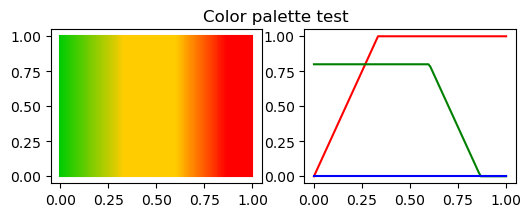

In [2]:
# %config InlineBackend.figure_formats = ['svg']

import pandas as pd
import conf
from matplotlib import pyplot as plt

def get_color(flow, use_opacity=False):
    r = np.clip(np.clip(flow * 3, 0, 1) + 0, 0, 1)
    g = np.clip(0.8 - 3 * np.clip(flow - 0.6, 0, 1), 0, 1)
    b = 0 * flow
    a = np.clip(5*flow, 0, 1)
    if use_opacity:
        return (r, g, b, a)
    return (r, g, b)

f, axs = plt.subplots(1, 2, figsize=(6, 2))
flow = np.linspace(0, 1, 100)
for i in range(len(flow)):
    axs[0].plot([flow[i], flow[i]], [0, 1], color=get_color(flow[i]))

axs[1].plot(flow, get_color(flow)[0], 'r')
axs[1].plot(flow, get_color(flow)[1], 'g')
axs[1].plot(flow, get_color(flow)[2], 'b')
if len(get_color(flow)) == 4:
    axs[1].plot(flow, get_color(flow)[3], 'k')
f.suptitle('Color palette test', fontsize=12);

In [3]:
coord_data = graph_data['graph_table'].copy()
flow_data = pd.read_csv(f'KEV_res/vladi/warm_start/flows/11_flows.txt', header=None, names=['flow'])
coord_data = coord_data.reset_index(drop=True)
combined_data = pd.merge(coord_data, flow_data, left_index=True, right_index=True)
# combined_data['flow'] = np.abs(combined_data['flow'] / combined_data['flow'].max())
combined_data = combined_data.sort_values('flow')
combined_data['probki'] = np.clip(combined_data['flow'] / combined_data['capacity'], a_min=0, a_max=40)
combined_data['probki'] = combined_data['probki'] / combined_data['probki'].max()
combined_data.head(3)

init_node  init_node_thru  term_node  term_node_thru  capacity  \
88342     632209            True     820023            True       500   
89424     157362            True     157351            True       500   
89423     157351            True     699978            True       500   

       free_flow_time             xa             xb            ya  \
88342        0.000708  736777.638381  736752.538105  4.784512e+06   
89424        0.001828  735416.546993  735432.475442  4.766716e+06   
89423        0.000181  735432.475442  735438.148961  4.766677e+06   

                 yb  flow  probki  
88342  4.784520e+06  -0.0    -0.0  
89424  4.766677e+06  -0.0    -0.0  
89423  4.766674e+06  -0.0    -0.0

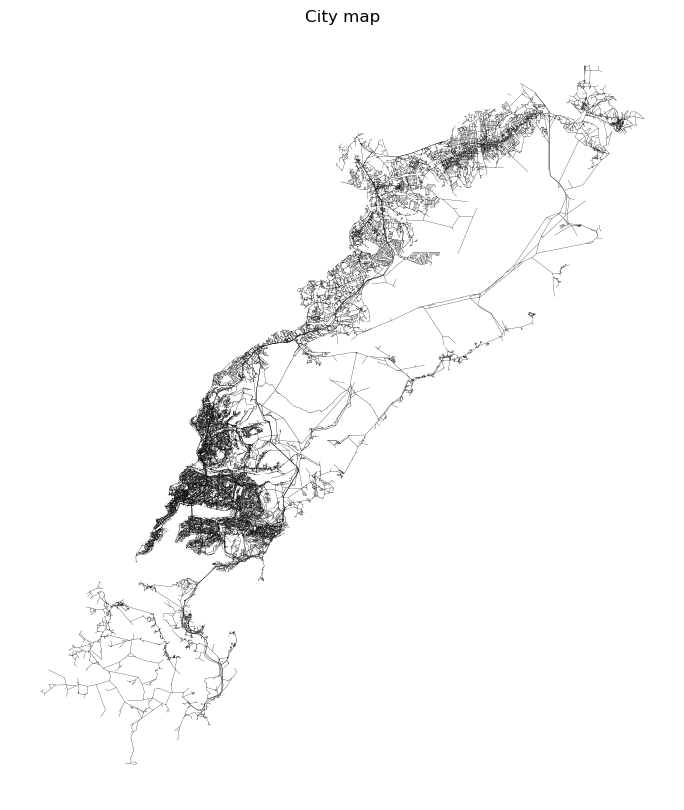

In [4]:
f, ax = plt.subplots(figsize=(10, 10))
for xa, xb, ya, yb, flow in combined_data.loc[:, ['xa', 'xb', 'ya', 'yb', 'probki']].to_numpy():
    ax.plot([xa, xb], [ya, yb], color='k', linewidth=(0.1 + 0.2 * flow))
ax.set_aspect('equal')
ax.set_title('City map')
ax.set_axis_off();

plt.savefig('vladi_map.png')
# plt.savefig('vladi_map.svg')

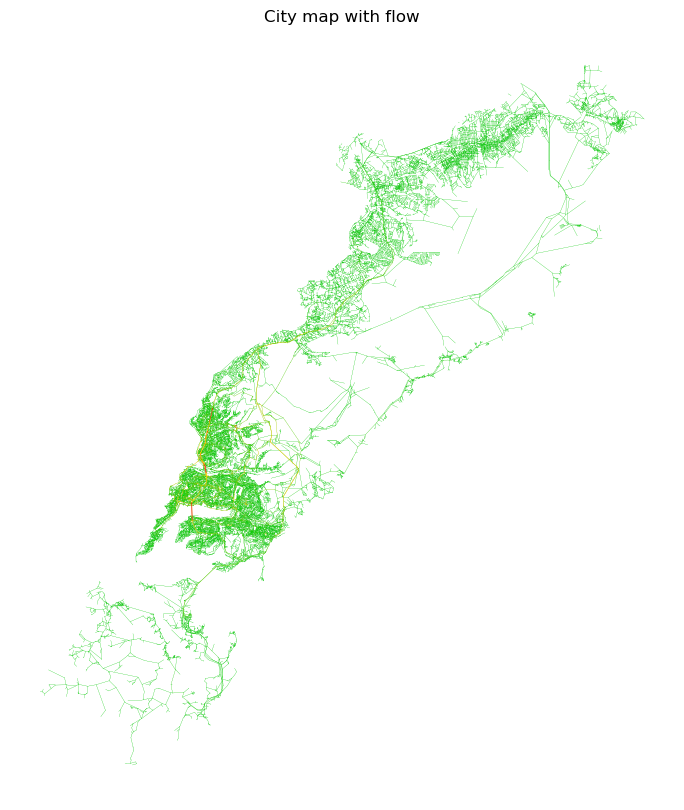

In [10]:
f, ax = plt.subplots(figsize=(10, 10))
for xa, xb, ya, yb, flow in combined_data.loc[:, ['xa', 'xb', 'ya', 'yb', 'probki']].to_numpy():
    ax.plot([xa, xb], [ya, yb], color=get_color(flow, use_opacity=False), linewidth=(0.1 + 0.2 * flow))
ax.set_aspect('equal')
ax.set_title('City map with flow')
ax.set_axis_off();

plt.savefig('vladi_map_with_flow_color.png')
# plt.savefig('vladi_map_with_flow_color.svg')

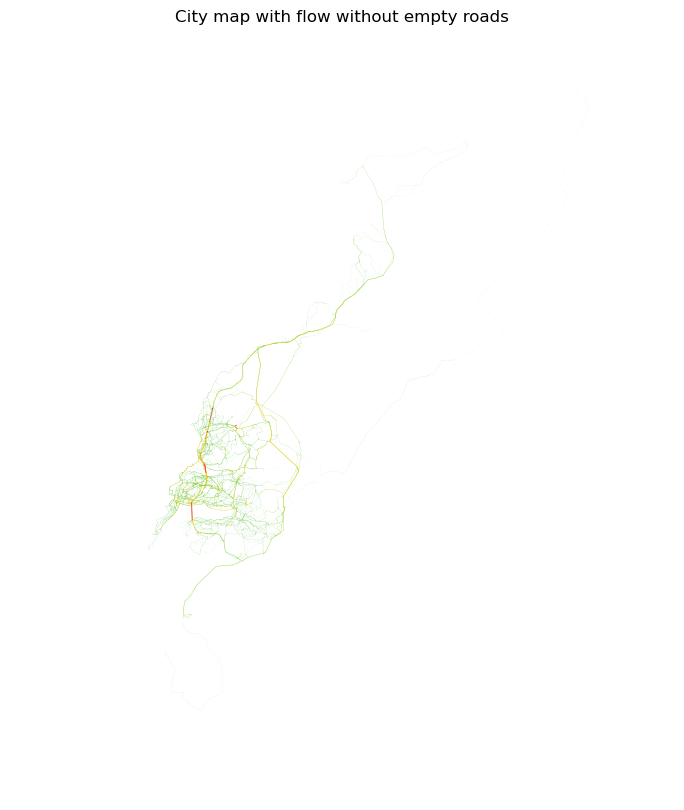

In [11]:
f, ax = plt.subplots(figsize=(10, 10))
for xa, xb, ya, yb, flow in combined_data.loc[:, ['xa', 'xb', 'ya', 'yb', 'probki']].to_numpy():
    ax.plot([xa, xb], [ya, yb], color=get_color(flow, use_opacity=True), linewidth=(0.1 + 0.2 * flow))
ax.set_aspect('equal')
ax.set_title('City map with flow without empty roads')
ax.set_axis_off();

plt.savefig('vladi_map_with_flow_color_opacity.png')
# plt.savefig('vladi_map_with_flow_color_opacity.svg')

### Для сравнения карта пробок Владивостока

<img src="ya_maps.png"/>